In [1]:
!pip install torch
!pip install matplotlib
!pip install torch-lr-finder

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import f1_score
import os
from google.colab import drive 
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch_lr_finder import LRFinder

In [3]:
data_dir = '/content/gdrive/My Drive/simpsons/classifier_data'

In [7]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load in and process data

Our dataset is structured so that we have folders, each of which is named after a character and contain images of only that character. Our dataset isn't already split into test and train so we need to write a function to do this 

In [8]:
def get_train_and_test_dataloaders(data_dir, test_pct, batch_size):
  # first define some transforms 
  if torch.cuda.is_available():
    pin_memory = True
    num_workers=1
  resize = transforms.Resize((255,255))
  to_tensor = transforms.ToTensor()
  normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
  horizontal_flip = transforms.RandomHorizontalFlip(p=0.3)
  random_crop = transforms.RandomCrop(90)

  # now compose these for the train and test datasets
  train_transforms = transforms.Compose([resize,
                                         horizontal_flip,
                                         #random_crop,
                                          to_tensor, 
                                          normalise])
  
  test_transforms = transforms.Compose([resize,
                                        to_tensor, 
                                        normalise])
  # get the dataset
  train_dataset = datasets.ImageFolder(data_dir, transform = train_transforms)
  test_dataset = datasets.ImageFolder(data_dir, transform = test_transforms)
  # get class to idx mapping 
  class_to_idx = train_dataset.class_to_idx
  # invert the class map (i.e. idx to class)
  idx_to_class = {v: k for k, v in class_to_idx.items()}
  # get number of photos 
  len_train = len(train_dataset)
  indicies = list(range(len_train))
  split = int(np.floor(test_pct * len_train))

  np.random.shuffle(indicies)

  train_idx, test_idx = indicies[split:], indicies[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)

  train_loader = torch.utils.data.DataLoader(train_dataset, 
                                             batch_size=batch_size, 
                                             sampler=train_sampler,
                                             num_workers=num_workers, 
                                             )
  
  test_loader = torch.utils.data.DataLoader(test_dataset, 
                                             batch_size=batch_size, 
                                             sampler=test_sampler,
                                             num_workers=num_workers, 
                                             )

  return train_loader, test_loader, class_to_idx, idx_to_class


In [9]:
train_loader, test_loader, class_to_idx, idx_to_class = get_train_and_test_dataloaders(data_dir = data_dir, test_pct = 0.2, batch_size = 32)

Let's take a look at the dataset:

principal_skinner,homer_simpson,barney_gumble,lionel_hutz,agnes_skinner,nelson_muntz,chief_wiggum,groundskeeper_willie,agnes_skinner,lionel_hutz


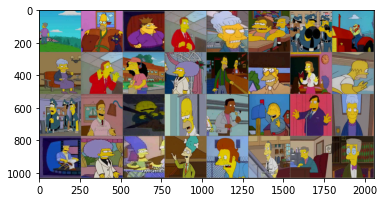

In [10]:
def imshow(img):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)
# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print(','.join('%5s' % idx_to_class[labels[j].item()] for j in range(10)))

## We have our train and test dataset, now let's get a pretrained model

In [11]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


We need to add a classifer to the top of our pretrained model

In [12]:
no_features = model.fc.in_features
model.fc = nn.Linear(no_features, 43)

We're trying to build a multi class classifier so let's use CrossEntropyLoss as out loss function and we'll pick SGD as our optimiser. At first we'll start with a very small learning rate

In [13]:
criterion = nn.CrossEntropyLoss()

Let's try lr of 3.76E-02 for 1 epoch using a the 1-cycle policy





In [15]:
lr = 3.76E-02
optimiser = optim.SGD(model.parameters(), lr = lr)

Build a fit function to train and evaluate the model as it's trained

In [16]:
def fit(model: nn.Module, 
        criterion, 
        optimiser, 
        epochs: int,
        lr: float,
        train_dataloader: 
        DataLoader, 
        test_dataloader: DataLoader, 
        audit_train: int = None):
  """
  Def to fit model, will automatically use GPU if avliable
  """
  
  def evaluate_performance(model: nn.Module, 
                           test_dataloader: DataLoader, 
                           test_acc: list, 
                           test_loss: list):
    batch_loss = 0
    total_test=0
    correct_test=0

    with torch.no_grad():

        model.eval()

        for data in (test_dataloader):
            images_test, labels_test = data
            if torch.cuda.is_available():
              images_test, labels_test = inputs.cuda(), labels.cuda()
            outputs_test = model(images_test)
            loss_test = criterion(outputs_test, labels_test)
            batch_loss += loss_test.item()
            _,predictions_test = torch.max(outputs_test, dim=1)
            correct_test += torch.sum(predictions_test==labels_test).item()
            total_test += labels_test.size(0)

        test_acc.append(100 * correct_test/total_test)
        test_loss.append(batch_loss/len(test_dataloader))
        
        print("\nValidation Loss: {:.4f} | Validation Accuracy: {:.4f}"
        .format(np.mean(test_loss),
                                    100 * correct_test/total_test))

  test_loss = []
  test_acc = []
  train_loss = []
  train_acc = []
  total_batches = len(train_loader)
  epoch_no = 0

  lr_sched = optim.lr_scheduler.OneCycleLR(optimizer = optimiser,
                                         max_lr = lr,
                                         epochs = epochs, 
                                         steps_per_epoch = 100,
                                         anneal_strategy = "cos", 
                                         cycle_momentum = True, 
                                         )

  if audit_train is None:
    audit_train = int(total_batches / 5)

  if torch.cuda.is_available():
    print("Using GPU")
    # move model to GPU
    model.cuda()

  for epoch in range(epochs):

      running_loss = 0.0
      correct = 0
      total= 0
      batch_no = 0

      for data in tqdm(train_loader):
          inputs, labels = data
          if torch.cuda.is_available():
            # move features and labels to GPU
            inputs, labels = inputs.cuda(), labels.cuda()
          # zero the parameter gradients
          optimiser.zero_grad()
          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimiser.step()
          running_loss += loss.item()

          _,predictions = torch.max(outputs, dim=1)
          correct += torch.sum(predictions==labels).item()
          total += labels.size(0)

          if batch_no % audit_train == 0:
              print ('\nEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch + 1, epochs , batch_no, total_batches, loss.item()))
          batch_no += 1
      train_acc.append(100 * correct / total)
      train_loss.append(running_loss/total_batches)

      evaluate_performance(model = model, test_dataloader = test_dataloader, test_acc = test_acc, test_loss = test_loss)

In [17]:
fit(model = model, criterion = criterion, lr = lr, optimiser = optimiser, epochs = 1, train_dataloader = train_loader, test_dataloader = test_loader, )

  0%|          | 0/736 [00:00<?, ?it/s]

Using GPU


  0%|          | 1/736 [00:07<1:27:24,  7.14s/it]


Epoch [1/1], Step [0/736], Loss: 3.7319


 20%|██        | 148/736 [14:46<56:01,  5.72s/it]


Epoch [1/1], Step [147/736], Loss: 1.2587


 40%|████      | 295/736 [29:36<43:45,  5.95s/it]


Epoch [1/1], Step [294/736], Loss: 0.5796


 60%|██████    | 442/736 [44:10<29:02,  5.93s/it]


Epoch [1/1], Step [441/736], Loss: 0.1621


 80%|████████  | 589/736 [58:42<14:20,  5.86s/it]


Epoch [1/1], Step [588/736], Loss: 0.0915


100%|██████████| 736/736 [1:12:59<00:00,  5.95s/it]


Epoch [1/1], Step [735/736], Loss: 0.4282



Validation Loss: 0.0070 | Validation Accuracy: 100.0000


After 1 epochs accuracy on the validation set is 100%

### Testing the trained model

As a "real world" test I've collated 16 images of characters to test the model. I used to following criteria / guidlines to chose these images:
- Each image has only one character in 
- The character in the image is (of course) one the model has seen before
- The character's face isn't obscured
- I haven't made any real effort to chose neutral or unbusy backgrounds, I'd like to see how the model does in general 

A function to create a sample dataloader

In [18]:
def get_sample_dataloader(data_dir, batch_size):

  if torch.cuda.is_available():
    pin_memory = True
    num_workers=1

  # first define some transforms 
  resize = transforms.Resize((255,255))
  to_tensor = transforms.ToTensor()
  normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


  
  sample_transforms = transforms.Compose([resize,
                                        to_tensor, 
                                        normalise])
  # get the dataset
  sample_dataset = datasets.ImageFolder(data_dir, transform = sample_transforms)
  
  sample_loader = torch.utils.data.DataLoader(sample_dataset, 
                                             batch_size=batch_size
                                              )

  return sample_loader


In [19]:
sample_dataloader = get_sample_dataloader('/content/gdrive/My Drive/simpsons_test/', batch_size = 19)

kent_brockman
barney_gumble
comic_book_guy
fat_tony
homer_simpson
milhouse_van_houten
bart_simpson
lisa_simpson
marge_simpson
ned_flanders
ned_flanders
ned_flanders
ned_flanders
nelson_muntz
rainier_wolfcastle
principal_skinner
sideshow_bob
groundskeeper_willie


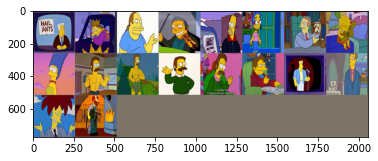

In [20]:
for data in sample_dataloader:
  images, labels = data
  if torch.cuda.is_available():
    images = images.cuda()
  outputs = model(images)
  _,predictions = torch.max(outputs, dim=1)
  for i in range(len(predictions)):
    print(idx_to_class[predictions[i].item()])
  images = images.cpu()
  imshow(torchvision.utils.make_grid(images))


Manually counting we can see that we got only 1 wrong, so an accuracy of 94%!